# Stability and convergence criteria for the linear response of $C_6H_6$

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = '/linear-response'

Autosave disabled


The aim of this notebook is to perform an assessment of the reliability of the results given by the linear response. 
First of all we analyze the absorption spectrum and discuss its stability in terms of both the number of virtual orbitals and the dimension of the simulation box. 
Then we try to define a set of tools for perfoming an analysis of the excitonic states of the system. We want to define a procedure that is able to state if a given excitation can be considered as "well-sampled" or not (using the given values of number of virtual states and dimension of the simulation box)

## Construction of the relevant dictionaries

We set some general parameters and perform the analysis reading the results obtained in the other notebook

In [2]:
numOrb = 15
simSetup = {
    'free-bc' : {'rmult' : [7.0,9.0], 'nVirtMax' : [235,239]}
    }

In [3]:
statPol = {}
spectrum = {}
excitations = {}
Data = {}
for bc,s in simSetup.iteritems():
    statPol[bc] = {}
    spectrum[bc] = {}
    excitations[bc] = {}
    Data[bc] = {}
    
    path = bc+outputpath
    print 'path is : ', path
    %cd $path
    for ind,r in enumerate(s['rmult']):
        filename = 'log/statPol_rmult_'+str(r)+'.yaml'
        statPol[bc][r] = Yaml.load(filename)
        filename = 'log/spectrum_rmult_'+str(r)+'.yaml'
        spectrum[bc][r] = Yaml.load(filename)
        #filename = 'log/excitations_singlena_rmult_'+str(r)+'.yaml'
        filename = 'log/excitations_rmult_'+str(r)+'.yaml'
        excitations[bc][r] = Yaml.load(filename)
        logpath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(s['nVirtMax'][ind])+'.yaml'
        log = !ls $logpath
        print log
        Data[bc][r] = lf.Logfile(log[0])
    %cd ../..

path is :  free-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response
['log/log-Rmult_7.0_numVirt_235.yaml']
['log/log-Rmult_9.0_numVirt_239.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6


## Analysis of the convergence of the statical polarizability

In [4]:
statPol_ref = [83.86,83.86,45.62]

Comparison of the i-component of the statical polarizability in function of the number of virtual orbitals (or of the maximum energy) for each of the simulation setup:

bc :  free-bc  rmult =  9.0 emax =  [2.0674910015000463, 3.1360645137553345, 4.1983030015152174, 5.2513005325746436, 6.5994741962899139, 8.0000601615635123, 9.5169539093893718, 10.600553990215611, 12.099070540888212]
bc :  free-bc  rmult =  7.0 emax =  [2.7468360760280621, 4.5571553623401124, 5.9713990380982986, 7.3252905777898132, 9.8745862730572735, 11.743362541438062, 13.987336741209404, 15.455093980994862, 17.632812848888086]


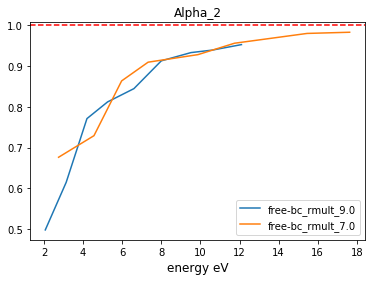

In [5]:
%matplotlib inline
alphaInd = 2
plotEnergy = True
for bc in statPol:
    for r,s in statPol[bc].iteritems():
        nalpha = s.keys()
        nalpha.sort()
        if plotEnergy:
            emax = [R.engMax(Data[bc][r],numOrb,na) for na in nalpha]
            print 'bc : ', bc, ' rmult = ', r, 'emax = ', emax
        else:
            print 'bc : ', bc, ' rmult = ', r, 'nalpha = ', nalpha
        val = [] 
        for na in nalpha:
            val.append(s[na][alphaInd])
        val = np.array(val)/statPol_ref[alphaInd]
        if plotEnergy:
            plt.plot(emax,val,label=bc+'_rmult_'+str(r))
        else:
            plt.plot(nalpha,val,label=bc+'_rmult_'+str(r))
plt.axhline(y=1.0, color='r', linestyle='--')
if plotEnergy:
    plt.xlabel('energy eV', size=12)
else:
    plt.xlabel('number of virtual orbitals', size=12)
plt.title('Alpha_'+str(alphaInd))
plt.legend()

## Stability of the  spectrum

Firstly we analyze the convergence of the spectrum in function of the number of virtual orbitals

In [6]:
bc = 'free-bc'
r = 9.0
part = 'imagPart'

239


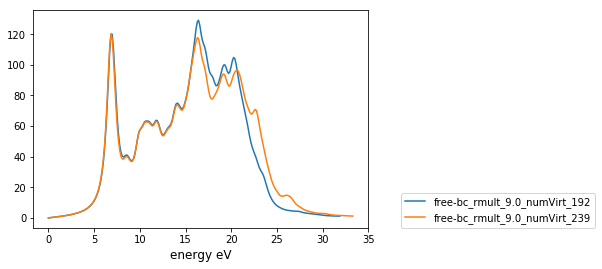

In [7]:
nVmax = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
print nVmax
na_plot = [32,160,192,256,nVmax]
for na in na_plot:
    if na in spectrum[bc][r]:
        plt.plot(spectrum[bc][r][na]['omega'],spectrum[bc][r][na][part],label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
plt.xlabel('energy eV', size=12)
plt.legend()
plt.legend(loc=(1.1,0))

The analysis of the plot for the two values of rmult show that:
* For rmult = 7.0 the spectrum is stable up to 35 eV
* For rmult = 9.0 the spectrum is stable up to 25 eV

Then we compare the spectrum with different boundary conditions

In [8]:
part = 'imagPart'

free-bc


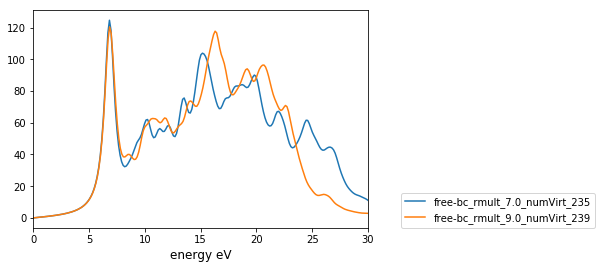

In [9]:
offs = 0.0
for bc,sim in simSetup.iteritems():
    print bc
    for r in sim['rmult']:
        na = simSetup[bc]['nVirtMax'][simSetup[bc]['rmult'].index(r)]
        plt.plot(spectrum[bc][r][na]['omega'],offs+np.array(spectrum[bc][r][na][part]),label = bc+'_rmult_'+str(r)+'_numVirt_'+str(na))
        #offs+=15
plt.xlabel('energy eV', size=12)
plt.xlim(0,30)
plt.legend(loc=(1.1,0))
plt.show()

It works in the same way also for the real part!

## Analysis of the excitations

We analyze the stability of the excitations below the threshold ($E_{homo}$ for $C_6H_6$ is 6.51 eV) for different values of rmult

In [10]:
E7 = excitations['free-bc'][7.0]
E9 = excitations['free-bc'][9.0]

build the list of the excitations below threshold (using E7)

In [11]:
aTr7 = R.allTransitions(E7)
trBT = []
for a in aTr7:
    if E7[235][a]['energy'] < 6.51:
        trBT.append(a)
trBT

[64, 128, 192, 235]


['14,15to1,2-0',
 '14,15to1,2-1',
 '14,15to1,2-2',
 '14,15to1,2-3',
 '14,15to1,2-4',
 '14,15to1,2-5',
 '15to3-0',
 '14to3-0',
 '15to3-1',
 '14to3-1']

build the list of the excitations above threshold that are in both E7 and E9

In [12]:
trAT = []
for a in aTr7:
    if a not in trBT and a in E9[239].keys():
        trAT.append(a)

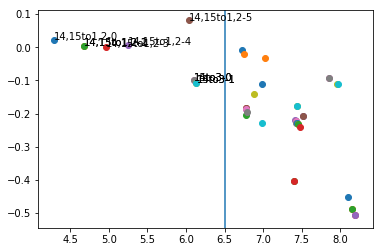

In [44]:
%matplotlib inline
for a in trBT:
    Energy7 = E7[235][a]['energy']
    deltaE = E9[239][a]['energy']-Energy7
    plt.scatter(Energy7,deltaE)
    plt.annotate(a,xy=(Energy7,deltaE))
for a in trAT[0:35]:
    Energy7 = E7[235][a]['energy']
    deltaE = E9[239][a]['energy']-Energy7
    plt.scatter(Energy7,deltaE)
plt.axvline(x=6.51)

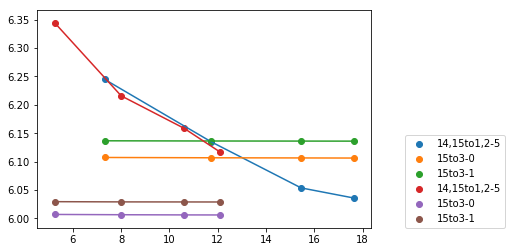

In [45]:
reload(R)
selLab = ['14,15to1,2-5','15to3-0','15to3-1']
R.pltTrLabel(selLab,excitations['free-bc'][7.0],Data['free-bc'][7.0],numOrb,True)
R.pltTrLabel(selLab,excitations['free-bc'][9.0],Data['free-bc'][9.0],numOrb,True)

Excitations 15to3-0 and 1 have a strange behaviour because they are below threshold and seems to be stable respect to nalpha, nonetheless their energy is quite different for rmult 7 and 9. The reason is the following: the virtual state 3 has an energy difference non negligible for rmult 7 and 9, so the transition that involves this state have different energies. This means that the box for rmult 7 is not able to contains this state in a proper way (the control for the box has been performed for the occupied perturbed orbitals and so only the bounded states with a size comparable to the one of $\rho'$ are correctly described in this box)

it is interesting to analyze in detail some excitations above threshold, that could be localized

In [46]:
eloc = ['9,10to1,2-0']

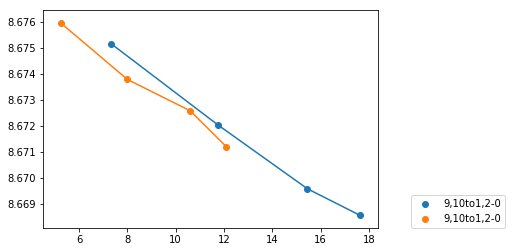

In [47]:
reload(R)
R.pltTrLabel(eloc,excitations['free-bc'][7.0],Data['free-bc'][7.0],numOrb,True)
R.pltTrLabel(eloc,excitations['free-bc'][9.0],Data['free-bc'][9.0],numOrb,True)

In [48]:
print excitations['free-bc'][7.0][235]['9,10to1,2-0']['energy']
print excitations['free-bc'][9.0][239]['9,10to1,2-0']['energy']

8.66854639066
8.67118524366


ok!

In [64]:
eloc2 = ['12,13to1,2-1','12,13to1,2-2','12,13to1,2-3','12,13to1,2-4','12,13to1,2-5']

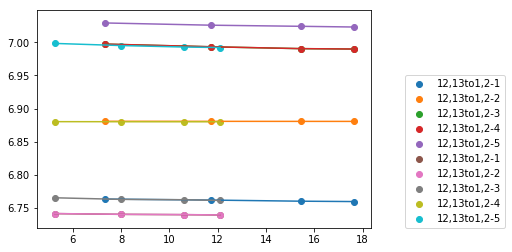

In [65]:
R.pltTrLabel(eloc2,excitations['free-bc'][7.0],Data['free-bc'][7.0],numOrb,True)
R.pltTrLabel(eloc2,excitations['free-bc'][9.0],Data['free-bc'][9.0],numOrb,True)

In [66]:
for e in eloc2:
    print excitations['free-bc'][7.0][235][e]['energy'], excitations['free-bc'][9.0][239][e]['energy']

6.75949557837 6.73924757652
6.88062794748 6.73932383281
6.98993656189 6.76120213508
6.98998788791 6.88008659882
7.02323559898 6.99220902384


Not all excitations are stable....